# Model Evaluation
### Linked scatterplots of model residuals, with value counts and average error scores for sub groups
### Tornado plot of feature importances

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

from ipywidgets import interact, fixed

import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
import data_munging_tools as dmt
import model_fitting_tools as mft
import model_eval_tools as met
import munge_williston_data as mwd
import munge_pipes

In [13]:
#specify columns for plotting
ip_day =  180
target_col = f"production_liquid_{ip_day}"
coord_cols = ["surface_lat", "surface_lng", "bh_lat", "bh_lng"]
target_units ="bbls"
cat_cols = ["originaloperator", "countyname", "stimulated_formation"]
cat_col = cat_cols[2]
tooltip_features = ["currentwellname", cat_col]

In [14]:
foi = ['currentwellname',
       'originaloperator',
       'tvd',
       'length',
       'prop_per_ft',
       'fluid_per_ft',
       'stage_spacing',
       'countyname',
       'stimulated_formation']

In [15]:
inspect_df = munge_pipes.make_inspect_df(coord_cols=coord_cols)

In [5]:
inspect_df.columns

Index(['bakken_isopach_ft', 'bh_lat', 'bh_lng', 'choke_size', 'countyname',
       'currentoperator', 'currentwellname', 'data_group', 'dfelev',
       'fieldname', 'fileno', 'footages', 'grelev', 'kbelev', 'leasename',
       'leasenumber', 'legs', 'max_tvd', 'mean_tvd', 'min_tvd',
       'num_pools_produced', 'originaloperator', 'originalwellname',
       'producedpools', 'production_liquid_120', 'production_liquid_150',
       'production_liquid_180', 'production_liquid_1825',
       'production_liquid_270', 'production_liquid_30',
       'production_liquid_365', 'production_liquid_60',
       'production_liquid_730', 'production_liquid_90', 'qq', 'range',
       'section', 'spud_date', 'std_tvd', 'stimulated_formation',
       'surface_lat', 'surface_lng', 'td', 'total_lbs_proppant',
       'total_num_stages', 'total_volume_bbls', 'township', 'tvd',
       'type_treatment', 'well_status_date', 'wellbore', 'wellstatus',
       'welltype', 'mid_lat', 'mid_lng', 'min_dist', 'length', 

In [6]:
eval_df = (pd.read_csv("../results/eval_df.tsv", sep="\t", dtype={"api": "O"})
                 .set_index("api")
                 .join(inspect_df)
                 .assign(day=ip_day)
                 .pipe(dmt.reduce_cardinality, cols=cat_cols)
#                          prod_rate=lambda x: x["actual"] / x["day"]
                        )

In [7]:
eval_df.columns

Index(['actual', 'pred', 'resid', 'perc_resid', 'abs_resid', 'abs_perc_resid',
       'bakken_isopach_ft', 'bh_lat', 'bh_lng', 'choke_size', 'countyname',
       'currentoperator', 'currentwellname', 'data_group', 'dfelev',
       'fieldname', 'fileno', 'footages', 'grelev', 'kbelev', 'leasename',
       'leasenumber', 'legs', 'max_tvd', 'mean_tvd', 'min_tvd',
       'num_pools_produced', 'originaloperator', 'originalwellname',
       'producedpools', 'production_liquid_120', 'production_liquid_150',
       'production_liquid_180', 'production_liquid_1825',
       'production_liquid_270', 'production_liquid_30',
       'production_liquid_365', 'production_liquid_60',
       'production_liquid_730', 'production_liquid_90', 'qq', 'range',
       'section', 'spud_date', 'std_tvd', 'stimulated_formation',
       'surface_lat', 'surface_lng', 'td', 'total_lbs_proppant',
       'total_num_stages', 'total_volume_bbls', 'township', 'tvd',
       'type_treatment', 'well_status_date', 'wellbore'

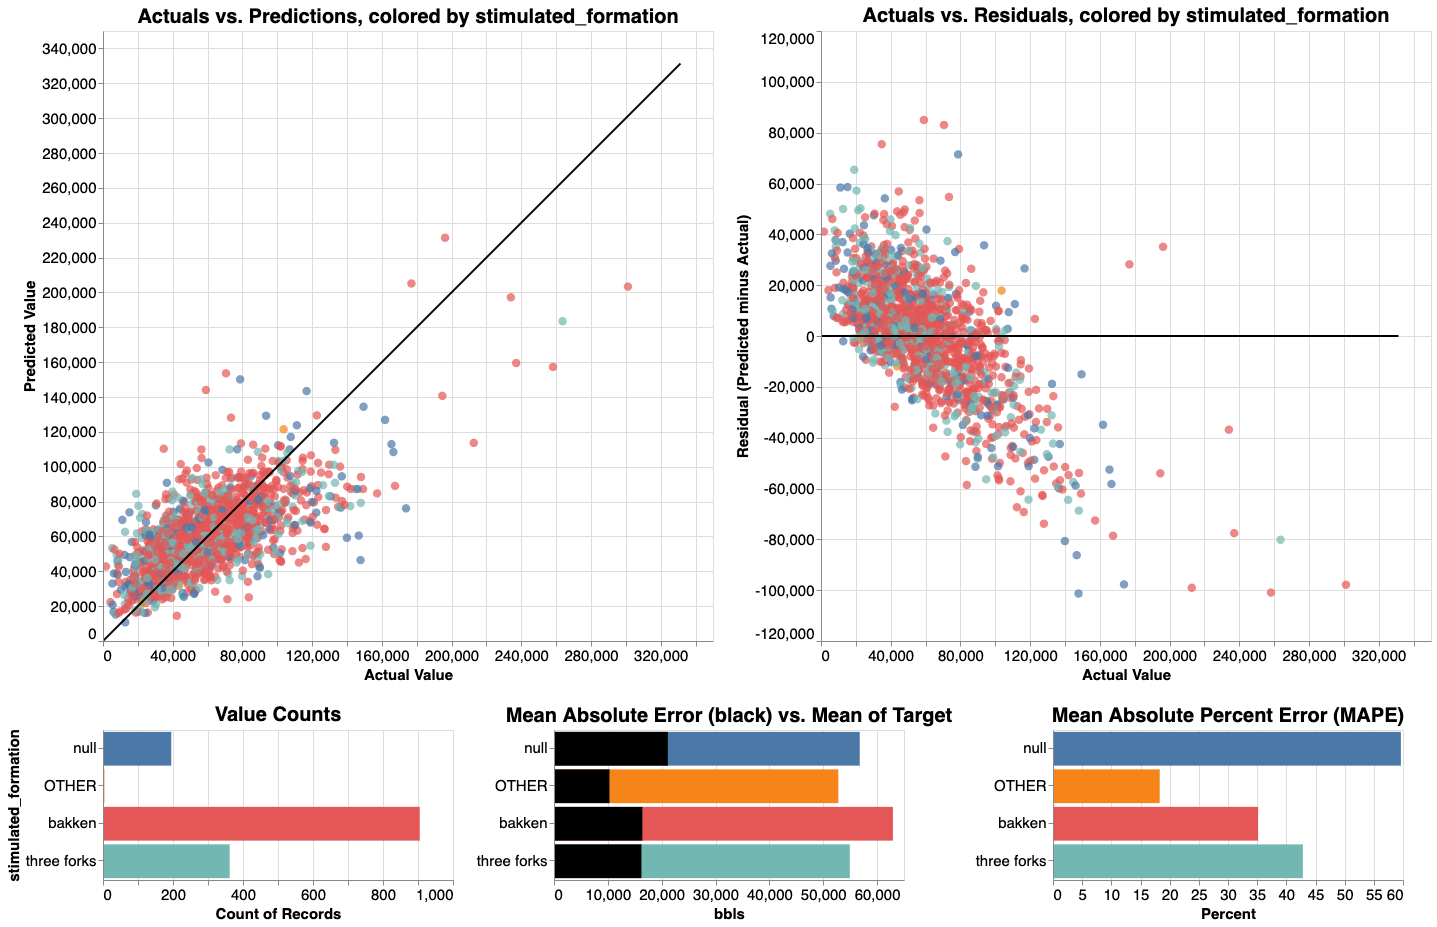

In [8]:
met.draw_resid_dashboard(eval_df, target_units, cat_col="stimulated_formation", tooltip_features=tooltip_features)

# Feature Importances

In [9]:
feat_imp_df = pd.read_csv("../results/feat_imp_df.tsv", sep="\t")

In [10]:
feat_imp_df

,feature,importance
0,total_lbs_proppant,0.243382
1,tvd,0.130013
2,min_dist,0.127202
3,bakken_isopach_ft,0.085474
4,choke_size,0.062077
5,total_num_stages,0.056933
6,total_volume_bbls,0.056773
7,length,0.052294
8,std_tvd,0.050504
9,stage_spacing,0.041399


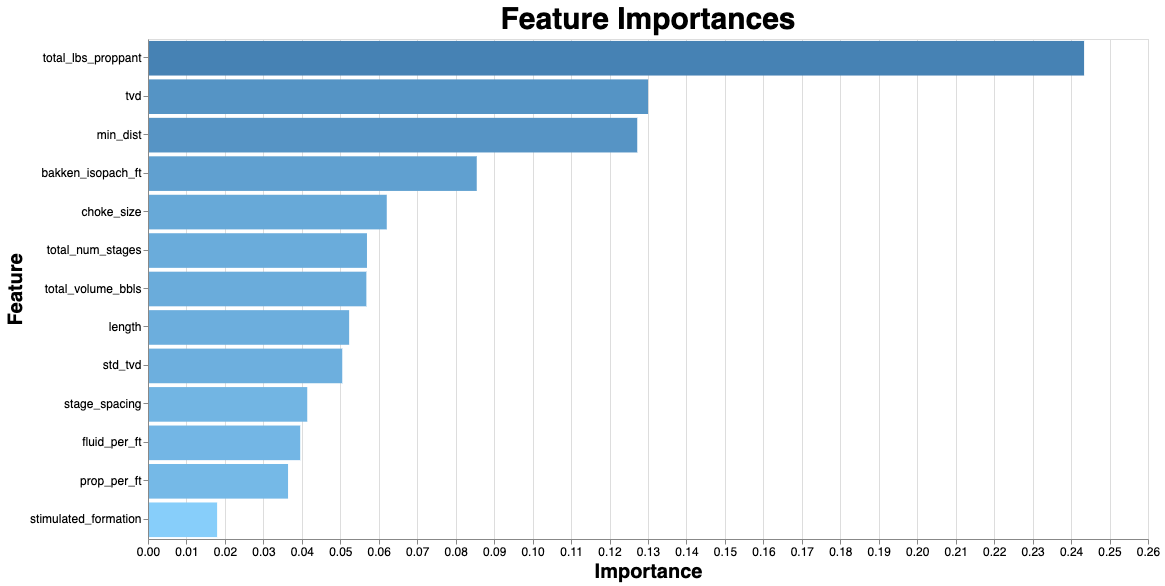

In [11]:
met.draw_feature_importance_tornado(feat_imp_df)

In [16]:
eval_df.abs_resid.mean()

16978.0681787176

### TODO
- [ ] Residuals and Absolute Percent Residuals on a map (with heatmap)
- [ ] Add new plot to examine residuals against continuous variables.

In [21]:
interact(met.draw_resid_dashboard, resids_df=fixed(eval_df), cat_col=cat_cols, tooltip_features=fixed(tooltip_features), target_units=fixed(target_units))

interactive(children=(Dropdown(description='cat_col', options=('originaloperator', 'countyname', 'stimulated_f…

<function model_eval_tools.draw_resid_dashboard(resids_df, target_units, cat_col, tooltip_features)>